<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/AnalisisDeDatos/2_Pivot_Table_y_Joins/clase-2-ejercicios-resueltos.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>
<div align="center"> Recordá abrir en una nueva pestaña </div>


# Clase 2: ejercicios prácticos resueltos

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

## Parámetros y extracción de datos

In [2]:
ESTIMACIONES_URL = "http://datos.agroindustria.gob.ar/dataset/9e1e77ba-267e-4eaa-a59f-3296e86b5f36/resource/95d066e6-8a0f-4a80-b59d-6f28f88eacd5/download/estimaciones-agricolas-al-30-09-2019.csv"
ESTIMACIONES_URL_S3 = "https://datasets-humai.s3.amazonaws.com/datasets/estimaciones_agricolas.zip"
ESTIMACIONES_PATH = "data/estimaciones-agricolas.csv"

In [3]:
converters = {
    "id_provincia": lambda x: str(x).zfill(2),
    "id_departamento": lambda x: str(x).zfill(3),
}

#estimaciones = pd.read_csv(ESTIMACIONES_URL, encoding="latin1", converters=converters)estimaciones = pd.read_csv(ESTIMACIONES_URL, encoding="latin1", converters=converters)
estimaciones = pd.read_csv(ESTIMACIONES_URL_S3, encoding="utf8", converters=converters)
#estimaciones.to_csv(ESTIMACIONES_PATH, encoding="utf8", index=False)
#estimaciones = pd.read_csv(ESTIMACIONES_PATH, converters=converters)

## Ejercicio 1 

Explorar descriptivamente el dataset de estimaciones agrícolas (https://datos.gob.ar/dataset/agroindustria-agricultura---estimaciones-agricolas) usando los elementos aprendidos en la clase 2, respondiendo las siguientes preguntas o mostrando:

* ¿Cuál es la producción total en toneladas estimada de todos los cultivos en la Argentina, cada año?
* ¿Cómo se distribuye el rendimiento (kg por hectárea) estimado promedio del cultivo de soja entre los departamentos que la siembran? ¿Qué tipo de distribución probabilística tiene? ¿Cuál es (y en qué departamento está) el rendimiento mínimo, mediano y máximo? ¿Cuál es el rendimiento promedio? ¿Hay valores potencialmente anómalos?
* Generá una tabla donde cada cultivo sea una columna, cada fila un año (una campaña) y los valores sean la producción total.

In [4]:
estimaciones.head()

,id_provincia,provincia,id_departamento,departamento,id_cultivo,cultivo,id_campaña,campaña,sup_sembrada,sup_cosechada,produccion,rendimiento
0,06,BUENOS AIRES,854,25 DE MAYO,1,Ajo,1,1969/1970,3,3,10,3333
1,06,BUENOS AIRES,854,25 DE MAYO,1,Ajo,2,1970/1971,1,1,3,3000
2,06,BUENOS AIRES,014,ADOLFO GONZALES CHAVES,1,Ajo,1,1969/1970,15,15,82,5467
3,06,BUENOS AIRES,014,ADOLFO GONZALES CHAVES,1,Ajo,2,1970/1971,10,10,55,5500
4,06,BUENOS AIRES,014,ADOLFO GONZALES CHAVES,1,Ajo,3,1971/1972,8,8,44,5500


In [5]:
estimaciones.columns

Index(['id_provincia', 'provincia', 'id_departamento', 'departamento',
       'id_cultivo', 'cultivo', 'id_campaña', 'campaña', 'sup_sembrada ',
       'sup_cosechada', 'produccion ', 'rendimiento'],
      dtype='object')

Algunos campos tienen espacios al final, es mejor tener nombres de campos sin espacios.

In [6]:
estimaciones.columns = [col.strip() for col in estimaciones.columns]

### Producción total anual 

In [7]:
estimaciones[["campania_inicio","campania_fin"]] = estimaciones.campaña.str.split("/", n=1,expand=True)

In [8]:
estimaciones["campania_inicio"] = estimaciones["campania_inicio"].astype(int)
estimaciones["campania_fin"] = estimaciones["campania_fin"].astype(int)

In [9]:
# pasamos los valores a millones
estimaciones["produccion"] = estimaciones.produccion.astype(float) / 1000000

In [10]:
produccion_anual = estimaciones.pivot_table(
    index="campania_fin",
    values="produccion",
    aggfunc="sum"
)

In [11]:
produccion_anual.tail()

,produccion
campania_fin,
2015,124.498769
2016,126.571125
2017,246.923268
2018,116.768681
2019,30.468652


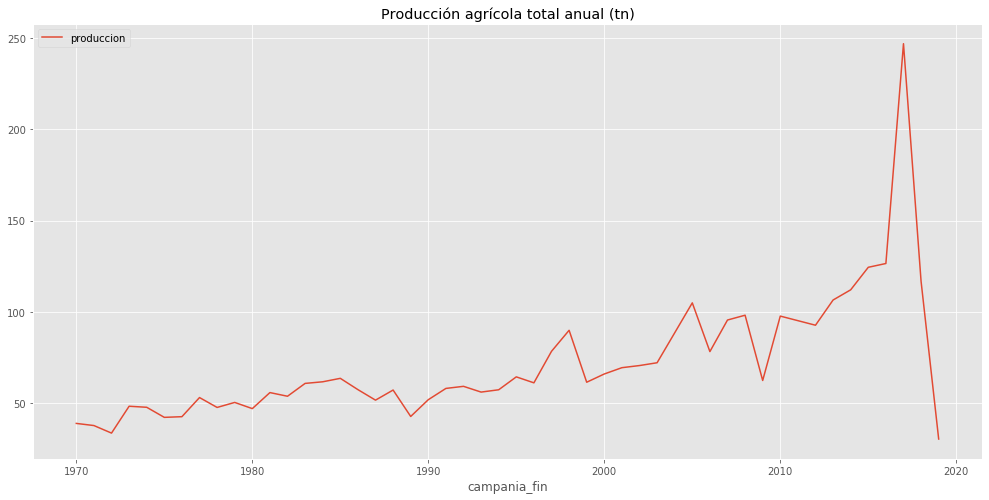

In [12]:
produccion_anual.plot(
    figsize=(17, 8),
    title="Producción agrícola total anual (tn)"
)

¿Está bien ese pico en la campaña 2016/2017? Hay que buscar algún control. https://www.invenomica.com.ar/desempeno-de-la-cosecha-agricola-argentina-2017-2018/ Parece que los datos de 2016/2017 están duplicados! Busquemos cuál es el error en el dataset.

In [13]:
estimaciones[estimaciones.campaña == "2016/2017"].produccion.sum()

141.203713

En realidad los datos de la campaña 2016/2017 parecen estar bien... el problema se da cuando sumamos por el el año de fin de campaña y 2017 aparece duplicado. Tal vez haya un error en los rótulos de las campañas.

In [14]:
estimaciones[["campaña", "campania_fin"]][
    estimaciones.campania_fin > 2000
].drop_duplicates().sort_values("campania_fin")

,campaña,campania_fin
643,2000/2001,2001
690,2001/2002,2002
691,2002/2003,2003
692,2003/2004,2004
693,2004/2005,2005
694,2005/2006,2006
695,2006/2007,2007
696,2007/2008,2008
697,2008/2009,2009
698,2009/2010,2010


Parece que la campaña 2010/2011 está incorrectamente rotulada como 2010/2017. Antes de seguir adelante, hay que hacer esa corrección.

In [15]:
estimaciones["campaña"] = estimaciones.campaña.str.replace("2010/2017", "2010/2011")

estimaciones[["campania_inicio","campania_fin"]] = estimaciones.campaña.str.split("/", n=1,expand=True)
estimaciones["campania_inicio"] = estimaciones["campania_inicio"].astype(int)
estimaciones["campania_fin"] = estimaciones["campania_fin"].astype(int)

In [16]:
produccion_anual = estimaciones.pivot_table(
    index="campania_fin",
    values="produccion",
    aggfunc="sum"
)

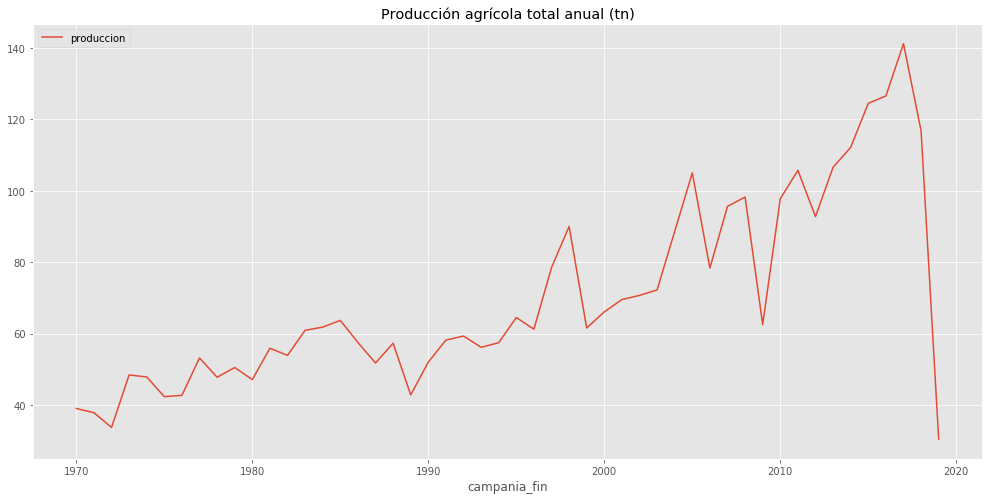

In [17]:
produccion_anual.plot(
    figsize=(17, 8),
    title="Producción agrícola total anual (tn)"
)

In [18]:
produccion_anual.tail()

,produccion
campania_fin,
2015,124.498769
2016,126.571125
2017,141.203713
2018,116.768681
2019,30.468652


La camapaña 2018/2019 está incompleta (el dataset fue actualizado en septiembre de 2019 por última vez) así que también debemos excluirla.

In [19]:
estimaciones = estimaciones[estimaciones.campaña != "2018/2019"]

##  Rendimiento promedio de la soja por departamento

In [20]:
estimaciones.cultivo.unique()

array(['Ajo', 'Alpiste', 'Avena', 'Cártamo', 'Cebada cervecera',
       'Cebada forrajera', 'Cebada total', 'Cebolla total', 'Centeno',
       'Colza', 'Girasol', 'Limón', 'Lino', 'Maíz', 'Mandarina', 'Maní',
       'Mijo', 'Naranja', 'Papa total', 'Pomelo', 'Poroto seco',
       'Soja total', 'Sorgo', 'Trigo candeal', 'Trigo total', 'Algodón',
       'Jojoba', 'Arroz', 'Caña de azúcar', 'Banana', 'Té', 'Tung',
       'Yerba mate'], dtype=object)

Ya que nos piden hacer una comparación de rendimientos de la soja entre departamentos, nos conviene realizar los filtros al principio y quedarnos con la muestra que nos interesa en una sola variable.

In [21]:
estimaciones_soja = estimaciones[
    (estimaciones.cultivo == "Soja total") &
    (estimaciones.campaña == "2017/2018")
]

In [22]:
len(estimaciones_soja.departamento.unique())

234

Hay 234 departamentos que producen Soja, y sobre los cuales hay que hacer el análisis.

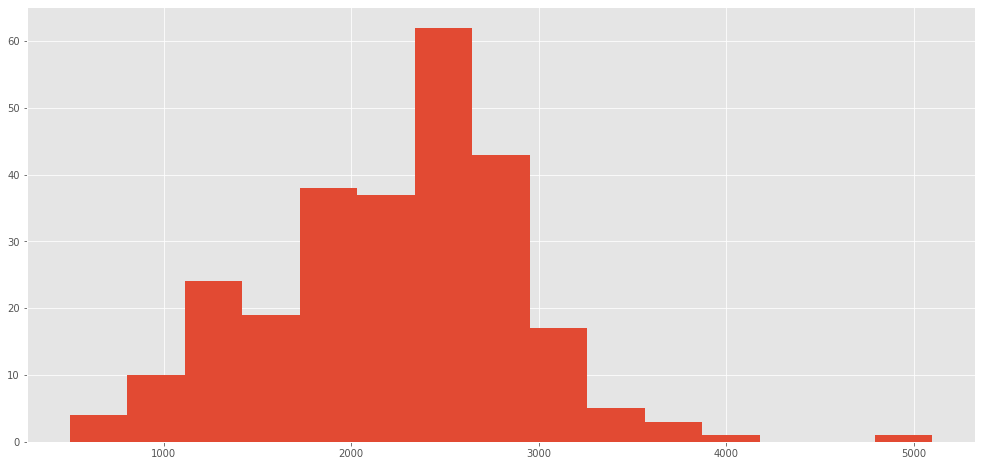

In [23]:
estimaciones_soja.rendimiento.hist(figsize=(17, 8), bins=15);

Los valores que se separan mucho del histograma, a primera vista podrían sospecharse como anómalos (ie. departamentos con rendimientos superiores a los 4000 kg. por hectárea deberían analizarse más profundamente).

In [24]:
estimaciones_soja.rendimiento.describe()

count     264.000000
mean     2233.602273
std       660.090901
min       500.000000
25%      1811.250000
50%      2326.000000
75%      2679.000000
max      5100.000000
Name: rendimiento, dtype: float64

In [25]:
estimaciones_soja[estimaciones_soja.rendimiento == estimaciones_soja.rendimiento.max()]

,id_provincia,provincia,id_departamento,departamento,id_cultivo,cultivo,id_campaña,campaña,sup_sembrada,sup_cosechada,produccion,rendimiento,campania_inicio,campania_fin
129988,86,SANTIAGO DEL ESTERO,182,SARMIENTO,25,Soja total,49,2017/2018,500,500,0.00255,5100,2017,2018


In [26]:
estimaciones_soja = estimaciones_soja.copy()
estimaciones_soja['diferencia_mediana'] = np.abs(estimaciones_soja.rendimiento - estimaciones_soja['rendimiento'].median())

In [27]:
estimaciones_soja[estimaciones_soja['rendimiento'] == estimaciones_soja['rendimiento'].median()]

,id_provincia,provincia,id_departamento,departamento,id_cultivo,cultivo,id_campaña,campaña,sup_sembrada,sup_cosechada,produccion,rendimiento,campania_inicio,campania_fin,diferencia_mediana


In [28]:
estimaciones_soja[estimaciones_soja['diferencia_mediana'] == estimaciones_soja['diferencia_mediana'].min()]

,id_provincia,provincia,id_departamento,departamento,id_cultivo,cultivo,id_campaña,campaña,sup_sembrada,sup_cosechada,produccion,rendimiento,campania_inicio,campania_fin,diferencia_mediana
33503,06,BUENOS AIRES,609,PEHUAJO,25,Soja total,49,2017/2018,138790,132090,0.303828,2300,2017,2018,26.0
108891,66,SALTA,042,CHICOANA,25,Soja total,49,2017/2018,220,220,0.000506,2300,2017,2018,26.0
123308,82,SANTA FE,021,CASTELLANOS,25,Soja total,49,2017/2018,251000,239000,0.562100,2352,2017,2018,26.0


In [29]:
estimaciones_soja[estimaciones_soja.rendimiento == estimaciones_soja.rendimiento.min()]

,id_provincia,provincia,id_departamento,departamento,id_cultivo,cultivo,id_campaña,campaña,sup_sembrada,sup_cosechada,produccion,rendimiento,campania_inicio,campania_fin,diferencia_mediana
90520,42,LA PAMPA,070,GUATRACHE,25,Soja total,49,2017/2018,1500,1000,0.0005,500,2017,2018,1826.0


### Tabla de evolución de producción por cultivo 

In [30]:
produccion_cultivo_evolucion = estimaciones.pivot_table(
    index="campaña",
    columns="cultivo",
    values="produccion",
    aggfunc="sum"
)
produccion_cultivo_evolucion

cultivo,Ajo,Algodón,Alpiste,Arroz,Avena,Banana,Caña de azúcar,Cebada cervecera,Cebada forrajera,Cebada total,...,Papa total,Pomelo,Poroto seco,Soja total,Sorgo,Trigo candeal,Trigo total,Tung,Té,Yerba mate
campaña,,,,,,,,,,,,,,,,,,,,,
1969/1970,0.049110,0.458200,0.107000,0.407000,0.425000,0.223440,9.700000,0.499500,0.070486,NaN,...,2.332170,0.130995,0.039388,0.026800,3.820000,NaN,7.019726,0.148600,0.111000,0.076788
1970/1971,0.049214,0.285000,0.039300,0.288000,0.359960,0.224800,10.260000,0.318500,0.048478,NaN,...,1.954034,0.143584,0.058920,0.059000,4.660000,NaN,4.919767,0.110000,0.129000,0.090460
1971/1972,0.050746,0.292200,0.026200,0.294000,0.475000,0.312700,12.870000,0.476000,0.077000,NaN,...,1.336735,0.139854,0.057923,0.078000,2.360000,NaN,5.439840,0.170000,0.131000,0.126714
1972/1973,0.054545,0.424000,0.035000,0.260000,0.566000,0.352160,16.870000,0.760000,0.120000,NaN,...,1.532375,0.179230,0.072791,0.271904,4.960000,NaN,7.896787,0.025000,0.128600,0.150963
1973/1974,0.066821,0.418400,0.034000,0.316000,0.561000,0.399400,15.536000,0.608000,0.124000,NaN,...,2.171698,0.177000,0.115150,0.495880,5.900000,NaN,6.559916,0.136000,0.140000,0.134529
1974/1975,0.067621,0.541000,0.025400,0.351000,0.327000,0.374300,15.600000,0.365000,0.065000,NaN,...,1.347890,0.185000,0.108535,0.485000,4.830000,NaN,5.969991,0.061000,0.165000,0.142308
1975/1976,0.068525,0.445000,0.032800,0.309000,0.432900,0.277500,14.310000,0.447800,0.074900,NaN,...,1.525481,0.180000,0.170390,0.695000,5.060000,NaN,8.570000,0.118000,0.133000,0.121135
1976/1977,0.072925,0.522000,0.039000,0.320000,0.530000,0.220000,16.000000,0.670000,0.090000,NaN,...,1.768320,0.170000,0.154798,1.400000,6.600000,0.582000,11.000000,0.100000,0.168000,0.127167
1977/1978,0.078900,0.786200,0.060000,0.310000,0.570000,0.128700,13.600000,0.290000,0.063000,NaN,...,1.592350,0.145000,0.132720,2.500000,7.200000,0.353100,5.299995,0.082400,0.103000,0.133436
